In [ ]:
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, RadioMapSolver
from scene_objects import create_scene_objects
from motion_engine import MotionEngine

In [18]:
mi.set_variant("llvm_ad_mono_polarized")

In [19]:
import sionna.rt as rt

In [20]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\downtown_chicago_script\DowntownChicago1KM.xml"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)

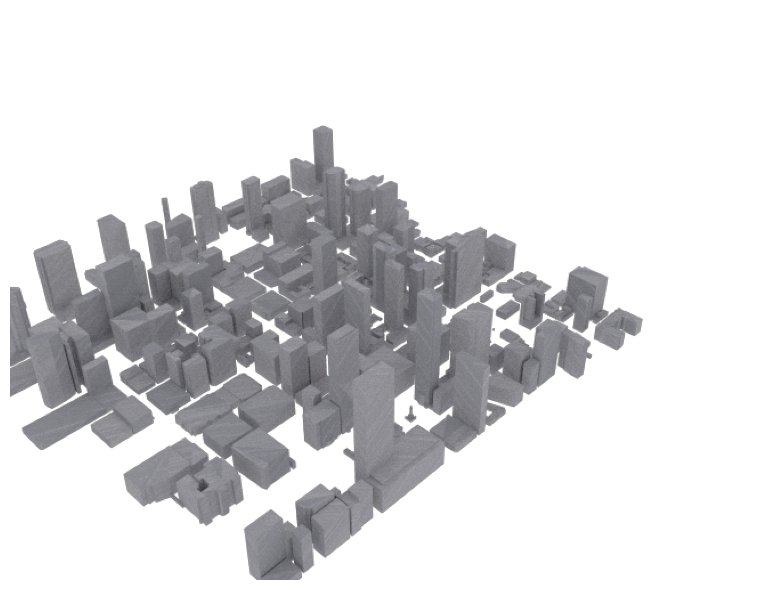

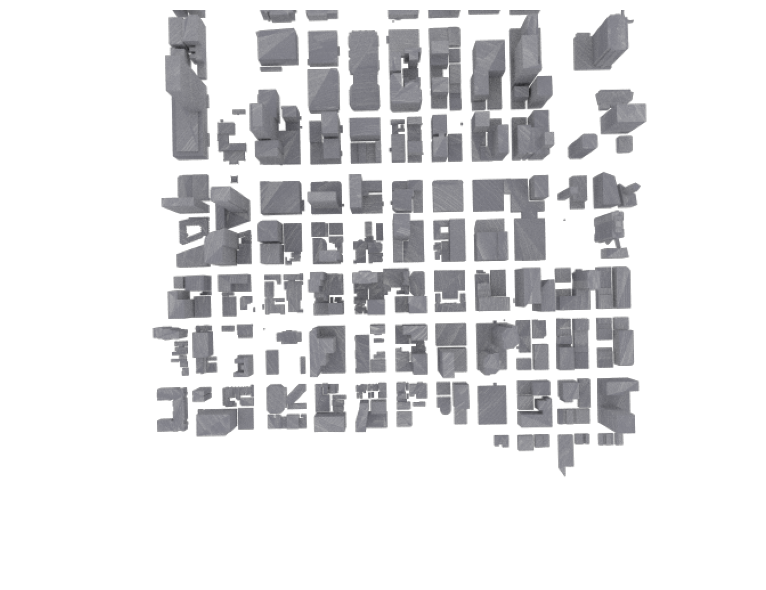

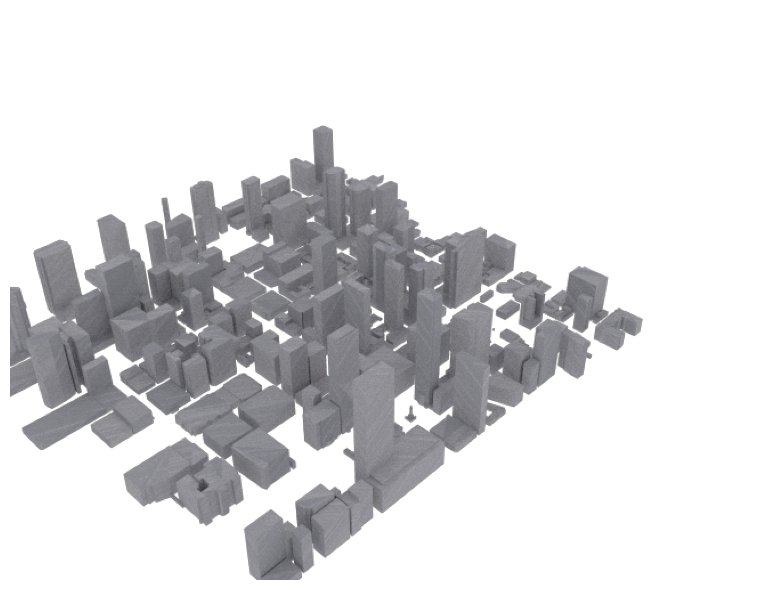

In [21]:
overhead = Camera(position=(0.0, 0.0, 2000.0))
overhead.look_at((0.0,0.0,0.0))
scene.render(camera=overhead)

isometric = Camera(position=(1200.0, 1200.0, 1200.0))
isometric.look_at((0.0,0.0,0.0))
scene.render(camera=isometric)

# Camera on render should be Z up, Y forwards!

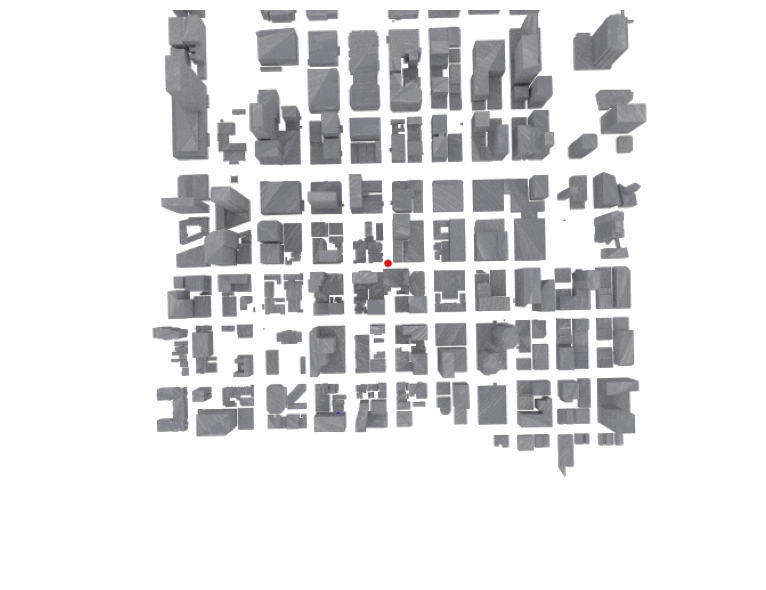

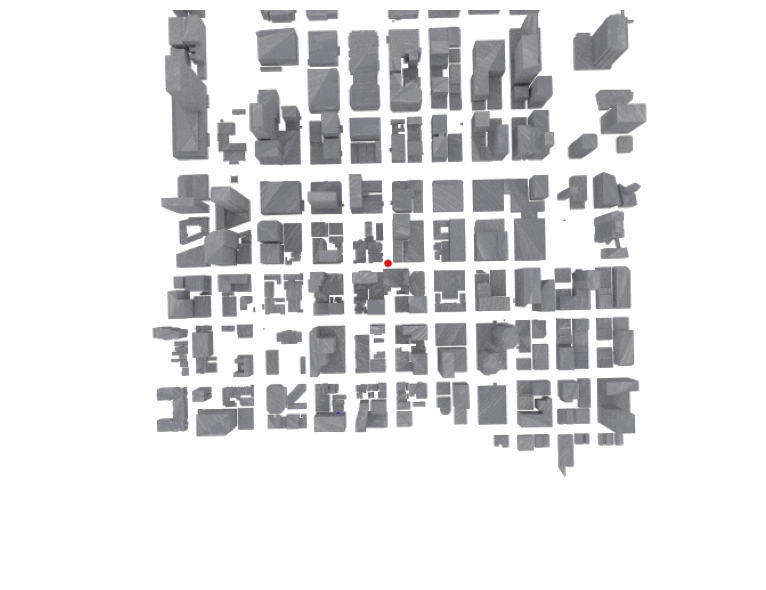

In [22]:
# Set up antenna arrays
scene.tx_array = rt.PlanarArray(num_rows=2, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# Add Transmitter
tx = Transmitter(name="Tx1", position=[70,-10,10], color=[1.0, 0.0, 0.0])
scene.add(tx)


tx_2 = Transmitter(name="Tx2", position=[-260,100,10], color=[0.0, 0.0, 1.0])
scene.add(tx_2)


# Visualize scene with transmitter and receivers in place
cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)

In [23]:
x_min, x_max = -500, 500
y_min, y_max = -500, 500
z_height = 10
cell_size = (20, 20)

map_width = x_max - x_min
map_height = y_max - y_min
map_center = [(x_min + x_max) / 2, (y_min + y_max) / 2, z_height]

rm_solver = RadioMapSolver()

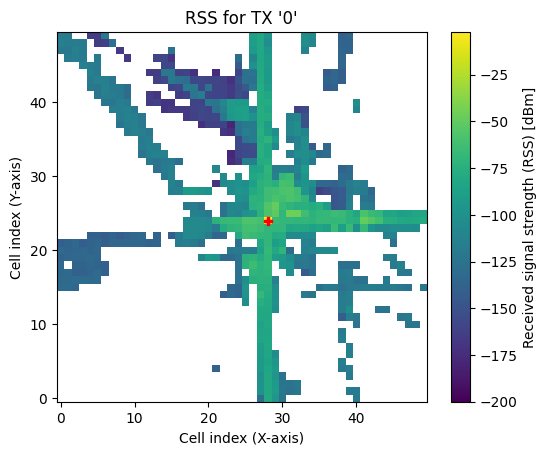

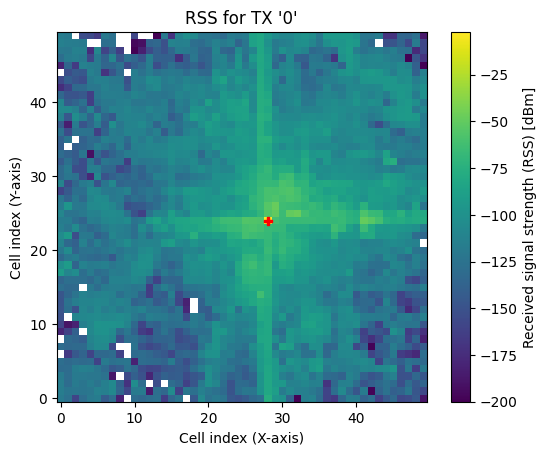

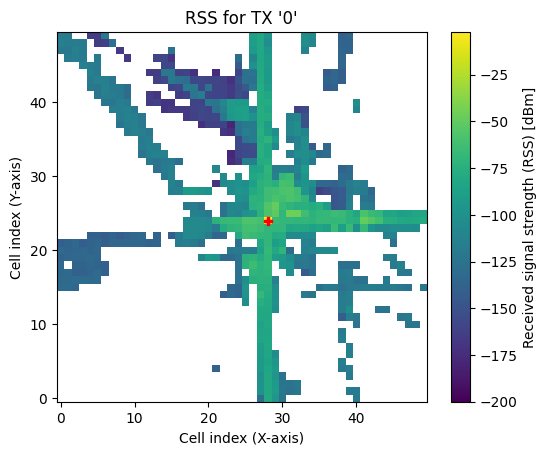

In [24]:
rm = rm_solver(
    scene,
    max_depth=25,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)

# RM with max depth 3 for comparison
rm_3 = rm_solver(
    scene,
    max_depth=3,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True,
)

rm.show(metric="rss", tx=0, show_tx=True, vmin=-200)
rm_3.show(metric="rss", tx=0, show_tx=True, vmin=-200)

# rss = np.array(rm.rss)
# print(f"{np.log(rss)}")

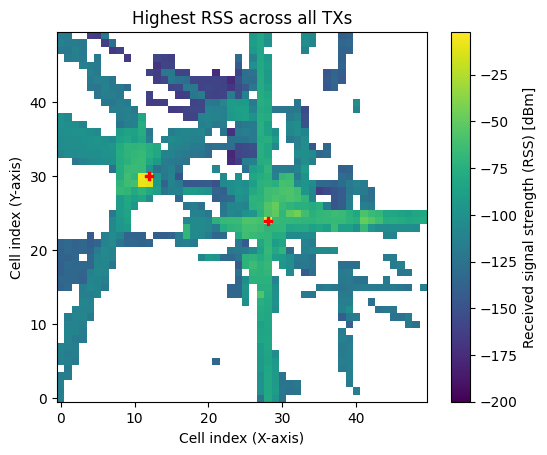

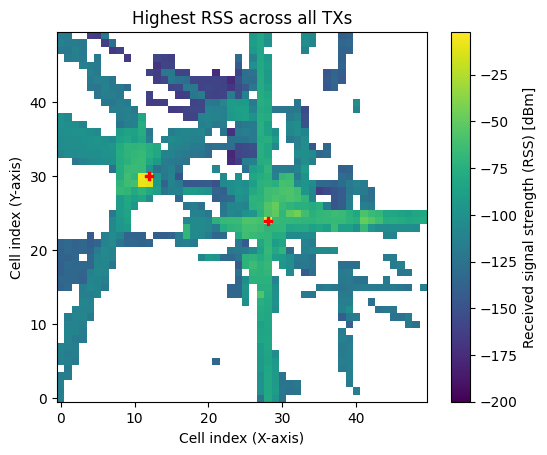

In [25]:
rm_2tx = rm_solver(
    scene,
    max_depth=3,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)

rm_2tx.show(metric="rss", tx=None, show_tx=True, vmin=-200)

In [26]:
scene.preview(radio_map=rm, rm_vmin=-160)

In [27]:
def generate_random_walk(starting_position, num_steps, step_size, 
                        time_step=0.1, 
                        z_fixed=True, 
                        bounds=None,
                        random_seed=None):

    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Initialize path
    path = np.zeros((num_steps, 3))
    path[0] = starting_position
    
    for step in range(1, num_steps):
        # Generate random direction
        direction = np.random.randn(3)
        
        # Fix z if needed
        if z_fixed:
            direction[2] = 0
        
        # Normalize and scale
        direction = direction / np.linalg.norm(direction)
        direction = direction * step_size
        
        # New position
        new_position = path[step - 1] + direction
        
        # Apply bounds if specified
        if bounds is not None:
            for i, axis in enumerate(['x', 'y', 'z']):
                if axis in bounds:
                    # Clip to bounds
                    new_position[i] = np.clip(new_position[i], 
                                             bounds[axis][0], 
                                             bounds[axis][1])
        
        path[step] = new_position
    
    # Calculate metadata
    distances = np.linalg.norm(np.diff(path, axis=0), axis=1)
    total_distance = np.sum(distances)
    avg_velocity = step_size / time_step if time_step > 0 else 0
    
    metadata = {
        'total_distance': total_distance,
        'avg_velocity': avg_velocity,
        'time_step': time_step,
        'num_steps': num_steps,
        'step_size': step_size
    }
    
    return path, metadata

In [28]:
#---------------------------------------Motion Engine Class---------------------------------------#

class MotionEngine:

    def __init__(self, scene, bounds=None):

        self.scene = scene
        self.bounds = bounds
        
        # Storage for jammer paths
        self.jammer_paths = {}
        self.jammer_metadata = {}
        
    def add_random_walk(self, jammer_id, starting_position, num_steps, 
                       step_size, time_step=0.1, z_fixed=True, random_seed=None):

        path, metadata = generate_random_walk(
            starting_position=starting_position,
            num_steps=num_steps,
            step_size=step_size,
            time_step=time_step,
            z_fixed=z_fixed,
            bounds=self.bounds,
            random_seed=random_seed
        )
        
        self.jammer_paths[jammer_id] = path
        self.jammer_metadata[jammer_id] = metadata
        
        print(f"Generated path for '{jammer_id}':")
        print(f"  Total distance: {metadata['total_distance']:.2f} m")
        print(f"  Avg velocity: {metadata['avg_velocity']:.2f} m/s")
        
        return path, metadata
    
    def get_position_at_step(self, jammer_id, step_index):
        """Get position of a specific jammer at a specific step."""
        if jammer_id not in self.jammer_paths:
            raise ValueError(f"Jammer '{jammer_id}' not found")
        
        path = self.jammer_paths[jammer_id]
        if step_index >= len(path):
            return None
        
        return path[step_index]
    
    def get_all_positions_at_step(self, step_index):
        
        positions = {}
        for jammer_id, path in self.jammer_paths.items():
            if step_index < len(path):
                positions[jammer_id] = path[step_index]
        
        return positions
    
    def update_scene_transmitters(self, step_index):

        positions = self.get_all_positions_at_step(step_index)
        
        for jammer_id, position in positions.items():
            try:
                tx = self.scene.get(jammer_id)
                tx.position = position
            except:
                print(f"Warning: Transmitter '{jammer_id}' not found in scene")
    
    def get_max_path_length(self):
        """Return the length of the longest path."""
        if not self.jammer_paths:
            return 0
        return max(len(path) for path in self.jammer_paths.values())
    
    def create_path_matrix(self, padding_mode='pad_end'):

        if not self.jammer_paths:
            raise ValueError("No jammer paths found")
        
        max_steps = self.get_max_path_length()
        path_lengths = {jid: len(path) for jid, path in self.jammer_paths.items()}
        
        # Check if all paths are equal length
        all_equal = len(set(path_lengths.values())) == 1
        
        if padding_mode == 'error' and not all_equal:
            raise ValueError(f"Path lengths are not equal: {path_lengths}. "
                            f"Use different padding_mode or ensure equal lengths.")
        
        if padding_mode == 'none':
            print("Returning unpadded paths")
            return self.jammer_paths, max_steps
        
        # Create padded matrix
        padded_paths = {}
        
        for jammer_id, path in self.jammer_paths.items():
            path_len = len(path)
            
            if path_len == max_steps:
                padded_paths[jammer_id] = path
            else:
                pad_amount = max_steps - path_len
                
                if padding_mode == 'pad_end':
                    # Pad with last position
                    last_pos = path[-1]
                    padding = np.tile(last_pos, (pad_amount, 1))
                    padded_path = np.vstack([path, padding])
                    
                elif padding_mode == 'pad_start':
                    # Pad with first position
                    first_pos = path[0]
                    padding = np.tile(first_pos, (pad_amount, 1))
                    padded_path = np.vstack([padding, path])
                
                else:
                    raise ValueError(f"Unknown padding_mode: {padding_mode}")
                
                padded_paths[jammer_id] = padded_path
                print(f"Padded '{jammer_id}' from {path_len} to {max_steps} steps (mode: {padding_mode})")
        
        return padded_paths, max_steps

Generated path for 'Tx1':
  Total distance: 20.00 m
  Avg velocity: 10.00 m/s
Generated path for 'Tx2':
  Total distance: 40.00 m
  Avg velocity: 10.00 m/s
Padded 'Tx1' from 3 to 5 steps (mode: pad_end)
Tx1 position: [70.0, -10.0, 10.0]
Tx2 position: [-260.0, 100.0, 10.0]
Tx1 position: [79.3, -13.6, 10.0]
Tx2 position: [-250.8, 103.8, 10.0]
Tx1 position: [86.6, -20.5, 10.0]
Tx2 position: [-252.9, 94.0, 10.0]
Tx2 position: [-260.1, 101.0, 10.0]
Tx2 position: [-253.5, 108.5, 10.0]


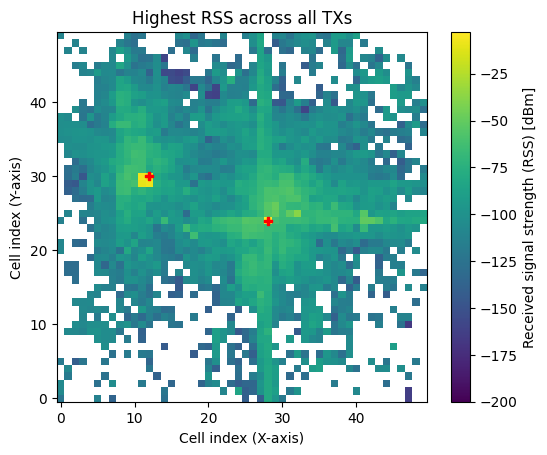

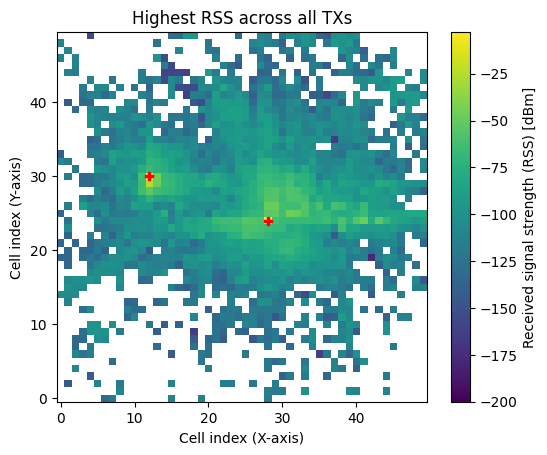

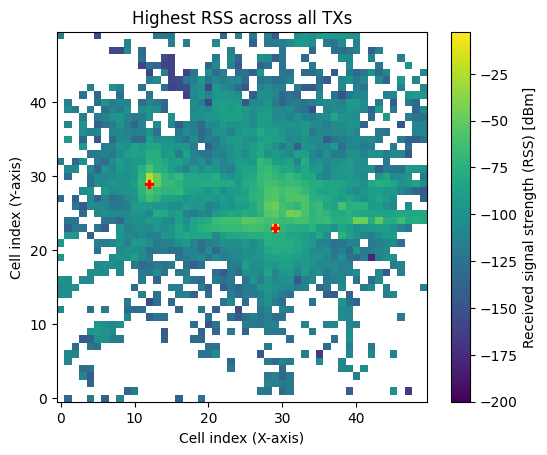

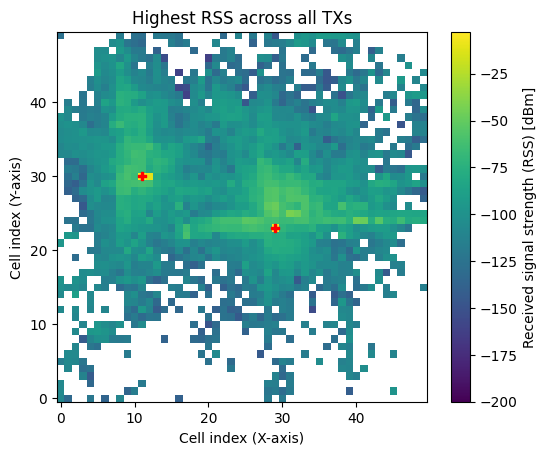

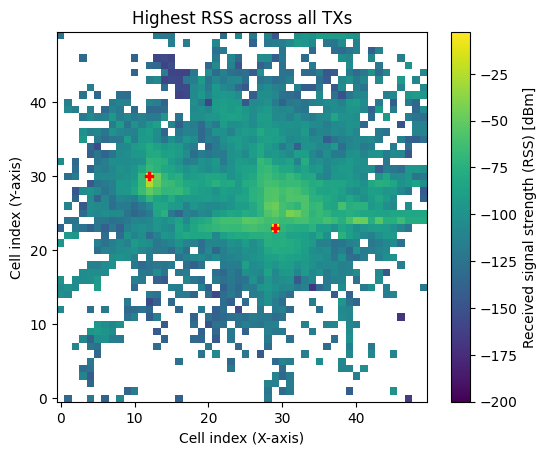

In [29]:
bounds = {
    'x': [-500, 500],
    'y': [-500, 500],
    'z': [10, 10]  # Keep jammers at 10m height
}

engine = MotionEngine(scene, bounds=bounds)

engine.add_random_walk(
    jammer_id="Tx1",
    starting_position=[70, -10, 10],
    num_steps=3,
    step_size=10.0,
    time_step=1.0,
    z_fixed=True
)

engine.add_random_walk(
    jammer_id="Tx2",
    starting_position=[-260, 100, 10],
    num_steps=5,
    step_size=10.0,
    time_step=1.0,
    z_fixed=True
)
# Create synchronized paths
padded_paths, max_steps = engine.create_path_matrix(padding_mode='pad_end')

# Radio map solver setup
x_min, x_max = -500, 500
y_min, y_max = -500, 500
z_height = 10
cell_size = (20, 20)

map_width = x_max - x_min
map_height = y_max - y_min
map_center = [(x_min + x_max) / 2, (y_min + y_max) / 2, z_height]

rm_solver = RadioMapSolver()

# Loop through each time step and generate radio maps
for step in range(max_steps):
    
    # Update transmitter positions in the scene
    engine.update_scene_transmitters(step)
    
    # Print current positions
    positions = engine.get_all_positions_at_step(step)
    for jammer_id, pos in positions.items():
        print(f"{jammer_id} position: [{pos[0]:.1f}, {pos[1]:.1f}, {pos[2]:.1f}]")
    
    # Compute radio map at this time step
    rm = rm_solver(
        scene,
        max_depth=10,
        samples_per_tx=10**6,  # Reduced from 10**7 for faster computation
        cell_size=cell_size,
        center=map_center,
        size=[map_width, map_height],
        orientation=[0, 0, 0],
        diffraction=True,
        refraction=True,
        edge_diffraction=True
    )
    
    # Show radio map with both transmitters
    rm.show(metric="rss", tx=None, show_tx=True, vmin=-200)

In [30]:
print(padded_paths)

{'Tx1': array([[ 70.        , -10.        ,  10.        ],
       [ 79.32743923, -13.60539559,  10.        ],
       [ 86.55084605, -20.52076933,  10.        ],
       [ 86.55084605, -20.52076933,  10.        ],
       [ 86.55084605, -20.52076933,  10.        ]]), 'Tx2': array([[-260.        ,  100.        ,   10.        ],
       [-250.75337107,  103.80786731,   10.        ],
       [-252.87421052,   94.03535279,   10.        ],
       [-260.09241961,  100.95615169,   10.        ],
       [-253.4762621 ,  108.45458218,   10.        ]])}


In [31]:
print(len(scene.objects))

for i, name in enumerate(scene.objects.values(), 1):
    print(f"{i}. {name}")

print("\n")

for i, name in enumerate(scene.objects.keys(), 1):
    print(f"{i}. {name}")

2
1. <sionna.rt.scene_object.SceneObject object at 0x0000021BD673D710>
2. <sionna.rt.scene_object.SceneObject object at 0x0000021BB02EDFD0>


1. no-name-3
2. no-name-4


In [32]:
for k, obj in scene.objects.items():
    print(k, type(obj), obj)

no-name-3 <class 'sionna.rt.scene_object.SceneObject'> <sionna.rt.scene_object.SceneObject object at 0x0000021BD673D710>
no-name-4 <class 'sionna.rt.scene_object.SceneObject'> <sionna.rt.scene_object.SceneObject object at 0x0000021BB02EDFD0>
